In [1]:
%matplotlib inline 
import mysql.connector
from textblob import TextBlob
from scipy.spatial.distance import cosine
from TrainTest import TrainTest
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import re
from gensim import corpora, models, similarities
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import pairwise_distances
import csv
import scipy.sparse as sp
from scipy.sparse.linalg import svds
pd.options.mode.chained_assignment = None


In [2]:
#connect to mysql
cnx = mysql.connector.connect(host='152.19.68.141', user='ctolson', password='ilaYOU5!', database='sephora_cosmetics')
cursor = cnx.cursor()

#query reviews by product1
query = ("SELECT R.product_id, review_id, review, reviewer, type "
         "FROM Reviews as R "
         "JOIN Product as P "
         "ON P.product_id = R.product_id")
cursor.execute(query)


#close mysql server
cnx.close()

In [3]:
#clean reviews data
product_id = []
review_id = []
reviews = []
reviewers = []
types = []
for (x, y, z, w, v) in cursor:
    product_id.append(int(x))
    review_id.append(int(y))
    reviews.append(z)
    reviewers.append(w)
    types.append(v)

#convert to data frame
data = list(zip(product_id, review_id, reviews, reviewers, types))
review_data = pd.DataFrame(data=data, index=range(0,len(reviews)), columns=['product_id', 'review_id', 'reviews', 'reviewers', 'types'])


In [4]:
#get training set review ids
training = TrainTest()
ttset = training.getSet()
train = ttset['train']

#create training set
review_train = review_data.loc[review_data['review_id'].isin(train)]
product_id = review_train.groupby('product_id')['product_id'].first().tolist()

#convert series to lists
reviews = review_train['reviews'].tolist()


In [17]:
#get sentiment polarity for reviews
sentiment = [TextBlob(x).sentiment.polarity for x in reviews]
sentiment = pd.Series(sentiment, index=review_train.index)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x117bd87b8>]], dtype=object)

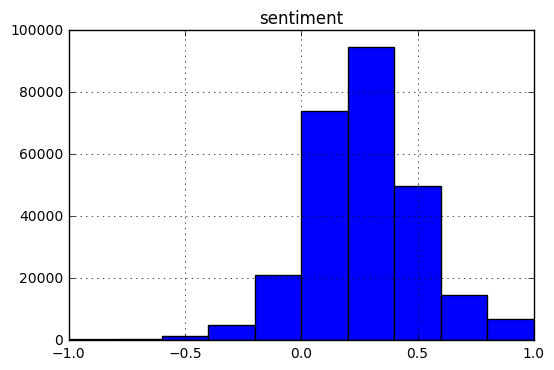

In [18]:
#get sentiment histogram
review_train['sentiment'] = sentiment
review_train.hist('sentiment')

In [25]:
#convert to binary sentiment
#sentiment = [int(x>0.25) for x in sentiment]

#create user-item matrix
review_train['sentiment'] = sentiment
review_pivot = pd.pivot_table(review_train, index='product_id',columns='reviewers',values='sentiment',fill_value=0)

#open file 
fl = open('../../Data/dist_reviews_item.csv', 'w')
writer = csv.writer(fl)
writer.writerow(['product_id']+product_id)

#get pairwise distances
dist = pairwise_distances(review_pivot, metric='cosine')
dist = [list(x) for x in dist]

#save pairwise distances
count = 0
for i in dist:
    d = [1-x for x in i]
    out = [product_id[count]]+d
    writer.writerow(out)
    count = count+1

#close file
fl.close()